<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_compare_tumor_features_with_mutation_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISB-CGC Community Notebooks

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   Co-analyzing tumor radiomics features with somatic mutations
Author:  Fabian Seidl, Boris Aguilar
Created: 2021-06-15
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_compare_tumor_features_with_mutation_data.ipynb
Purpose: To demonstrate multi-omics data analysis using table joins in Google BigQuery
Notes: 
```

# Overview
This notebook showcases an analysis workflow combining tumor radiomics features with mutation data mostly run in Google BigQuery. In this notebook we will:


> 1. Select and format mutation data from the Glioblastoma Multiforme TCGA project
> 2. Join these mutation data to tumor features extracted from radiomics data
> 3. Calculate t-test statistics for tumors with or without mutations in specific genes

The tumor radiomics feature data we used in this notebook are from Bakas et al. Nature Scientific 2017 (https://www.nature.com/articles/sdata2017117) and the mutation data come from the GDC data housed in ISB-CGC BigQuery tables.

First we initialize our python environment and authenticate our session.

In [ ]:
from google.colab import auth
import pandas_gbq
import pandas as pd
import numpy
import seaborn
from google.cloud import bigquery

bq_project='<your_google_project_here>'
auth.authenticate_user()
client = bigquery.Client(project=bq_project)
print('Authenticated')

Authenticated


# Joining the data
The mutation and feature data we will be using in this analysis are already formatted and stored in a dataset; we will be joining them on the unique TCGA barcodes with an SQL query before further downstream analyses.

In [ ]:
gdc_project = 'GBM'
mutation_table = 'isb-cgc-idc-collaboration.Analysis.{0}_genes_tidy_v1'.format(gdc_project)
feature_table = 'isb-cgc-idc-collaboration.Analysis.unpivoted_tcga_{0}_radiomicFeatures'.format(gdc_project.lower())

# selecting gene mutation data from a previously generated table
join_query1 = """
WITH
table2 AS (
    SELECT 
      '{0}' as Study, gene as symbol, 
      REPLACE(case_id,'_','-') AS ParticipantBarcode, present
    FROM `{1}`
),""".format(gdc_project, mutation_table)

# selecting tumor volumes
join_query2 = """
table1 AS ( 
  SELECT 
    '{0}' as Study, feature as symbol, 
    value as volume, ID as ParticipantBarcode 
  FROM `{1}`
  WHERE 
    feature LIKE 'VOLUME%' 
    AND ID IN (SELECT DISTINCT ParticipantBarcode FROM table2)  
)""".format(gdc_project, feature_table)

# the join operation for the previous two queries
join_query3 = """
SELECT
   n1.Study, n1.symbol as symbol1, n1.volume,
   n2.symbol as symbol2, n2.present
FROM table1 AS n1
INNER JOIN table2 AS n2
ON
   n1.ParticipantBarcode = n2.ParticipantBarcode
   AND n1.Study = n2.Study
   AND n2.present = 1
GROUP BY
   Study, symbol1, present, symbol2, volume
"""

query_job = client.query( join_query1 + join_query2 + join_query3 )
joined_data = query_job.result().to_dataframe()
joined_data.head(5)

,Study,symbol1,volume,symbol2,present
0,GBM,VOLUME_ET,50410,ENSG00000005339,1
1,GBM,VOLUME_ET,50410,ENSG00000011451,1
2,GBM,VOLUME_ET,50410,ENSG00000048707,1
3,GBM,VOLUME_ET,50410,ENSG00000064961,1
4,GBM,VOLUME_ET,50410,ENSG00000070018,1


We can "pipe" this query directly to the next one by simply appending the next step to our previous ones. With the usage of the `GROUP BY` command we can calculate the SUM() and SUM(squared) values for all cases that have a given mutation.

In [ ]:
# We can amend the third query from the previous cell as below
sum_query = """,
summ_table AS (
  SELECT 
   n1.Study, n1.symbol as symbol1,
   n2.symbol as symbol2,
   COUNT( n1.ParticipantBarcode) as n_1,
   SUM( n1.volume )  as sumx_1,
   SUM( n1.volume * n1.volume ) as sumx2_1
  FROM table1 AS n1
  INNER JOIN table2 AS n2
  ON
   n1.ParticipantBarcode = n2.ParticipantBarcode
   AND n1.Study = n2.Study
   AND n2.present = 1
  GROUP BY
   Study, symbol1, symbol2
)
""".format(gdc_project, mutation_table, feature_table)

select_all = 'SELECT * FROM summ_table'

#print(join_query1 + join_query2 + sum_query)
sum_query_job = client.query( join_query1 + join_query2 + sum_query +  select_all)
sum_table = sum_query_job.result().to_dataframe()
sum_table.head(5)

,Study,symbol1,symbol2,n_1,sumx_1,sumx2_1
0,GBM,VOLUME_ET,ENSG00000075275,5,192394,8226812092
1,GBM,VOLUME_ET,ENSG00000121879,8,179874,5586667456
2,GBM,VOLUME_ET,ENSG00000134853,6,227979,10828870733
3,GBM,VOLUME_ET,ENSG00000187775,5,174290,8141915644
4,GBM,VOLUME_ET,ENSG00000198626,8,169416,5436011400


The final step of this workflow is to run t-tests on our groups to calculate whether there are significant differences in expression.

In [ ]:
statistics_query = """,
statistics AS (
   SELECT n1.Study, symbol1, symbol2, n_1, 
       sumx_1 / n_1 as avg1,
       ( sumx2_1 - sumx_1*sumx_1/n_1 )/(n_1 -1) as var1, 
       n_t - n_1 as n_0,
       (sumx_t - sumx_1)/(n_t - n_1) as avg0,
       (sumx2_t - sumx2_1 - (sumx_t-sumx_1)*(sumx_t-sumx_1)/(n_t - n_1) )/(n_t - n_1 -1 ) as var0
   FROM  summ_table as n1
   LEFT JOIN ( SELECT Study, symbol, COUNT( ParticipantBarcode ) as n_t, SUM( volume ) as sumx_t, SUM( volume*volume ) as sumx2_t
            FROM table1 
            GROUP BY Study, symbol ) as n2
   ON symbol1 = symbol AND  n1.Study = n2.Study
   GROUP BY 1,2,3,4,5,6,7,8,9
   having var1 > 0 AND var0 > 0 AND n_1 > 5 AND n_0 > 5   
)
SELECT Study, symbol1 as radiomic_feature, symbol2 as Ensembl,  n_1 as n1, n_0 as n0,
       avg1, avg0,
       #ABS(avg1 - avg0)/ SQRT( var1 /n_1 + var0/n_0 ) as t,
       `cgc-05-0042.functions.jstat_ttest`(ABS(avg1 - avg0)/ SQRT( var1 /n_1 + var0/n_0 ), n_1+n_0-2, 2) as pvalue,
FROM statistics 
ORDER BY pvalue ASC"""

#print(join_query1 + join_query2 + sum_query)
stat_query_job = client.query( join_query1 + join_query2 + sum_query + statistics_query )
statistics_table = stat_query_job.result().to_dataframe()
statistics_table.head(5)

,Study,radiomic_feature,Ensembl,n1,n0,avg1,avg0,pvalue
0,GBM,VOLUME_ET_OVER_BRAIN,ENSG00000189056,6,51,0.008667273,0.021981289,0.000143
1,GBM,VOLUME_NET_OVER_ED,ENSG00000181143,12,45,0.084648854,0.362770122,0.000157
2,GBM,VOLUME_NET_OVER_WT,ENSG00000181143,12,45,0.053904044,0.146278682,0.000259
3,GBM,VOLUME_ET,ENSG00000189056,6,51,13418,31740.450980392,0.001939
4,GBM,VOLUME_TC_over_BRAIN,ENSG00000189056,6,51,0.01347415,0.033356212,0.001946


We can use these data for further analysis or simply generate a summary plot as below:

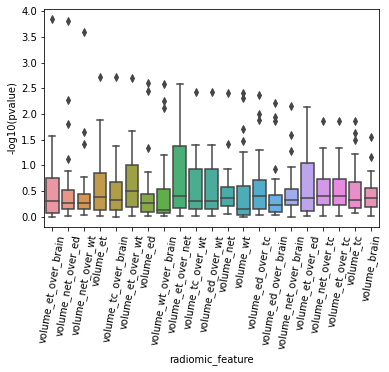

In [ ]:
statistics_table['neglog10'] = -numpy.log10(statistics_table['pvalue'])

bxplt = seaborn.boxplot(x=statistics_table['radiomic_feature'], 
                        y=statistics_table['neglog10'], 
                        data=statistics_table
                        )
labels = [x.get_text().lower() for x in bxplt.get_xticklabels()]
jnk = bxplt.set_xticklabels(labels, rotation=80, size=10)
jnk = bxplt.set(ylabel='-log10(pvalue)')

In [ ]:
# The full final query used to generate the data table
print( join_query1 + join_query2 + sum_query + statistics_query )


WITH
table2 AS (
    SELECT 
      'GBM' as Study, gene as symbol, 
      REPLACE(case_id,'_','-') AS ParticipantBarcode, present
    FROM `isb-cgc-idc-collaboration.Analysis.GBM_genes_tidy_v1`
),
table1 AS ( 
  SELECT 
    'GBM' as Study, feature as symbol, 
    value as volume, ID as ParticipantBarcode 
  FROM `isb-cgc-idc-collaboration.Analysis.unpivoted_tcga_gbm_radiomicFeatures`
  WHERE 
    feature LIKE 'VOLUME%' 
    AND ID IN (SELECT DISTINCT ParticipantBarcode FROM table2)  
),
summ_table AS (
  SELECT 
   n1.Study, n1.symbol as symbol1,
   n2.symbol as symbol2,
   COUNT( n1.ParticipantBarcode) as n_1,
   SUM( n1.volume )  as sumx_1,
   SUM( n1.volume * n1.volume ) as sumx2_1
  FROM table1 AS n1
  INNER JOIN table2 AS n2
  ON
   n1.ParticipantBarcode = n2.ParticipantBarcode
   AND n1.Study = n2.Study
   AND n2.present = 1
  GROUP BY
   Study, symbol1, symbol2
)
,
statistics AS (
   SELECT n1.Study, symbol1, symbol2, n_1, 
       sumx_1 / n_1 as avg1,
       ( sumx2_1 - sumx_1